In [2]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots","Images"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet: Knet, dir,sigm , zeroone, progress, sgd, load, save, gc, Param, KnetArray, gpu, Data, nll, training, dropout,conv4, pool, mat, nll, zeroone,
progress, sgd, param, param0, dropout, relu, Data,sigm, Adam, minibatch# param, param0, xavier
using Statistics: mean
using Base.Iterators: flatten
using Plots; default(fmt=:png,ls=:auto)
using Statistics
using Random
import Knet.param0
import Knet.param
import Knet.xavier
using Knet, Luxor, Plots,Printf

In [2]:
std(gaussian(5,3; std=0.05))

0.04089315538303144

In [3]:
using Images, Colors

In [4]:
# Some utilities to make model definitions easier:
param(d...; init=xavier, atype=atype())=Param(atype(init(d...)))
paramd1(d...; init=gaussian, atype=atype())=Param(atype(init(d...)))
paramd2(d...; init=gaussian, atype=atype())=Param(atype(init(d...;std=0.005)))
param0(d...; atype=atype())=param(d...; init=zeros, atype=atype)
param1(d...; atype=atype())=param(d...; init=ones, atype=atype)
xavier(o,i) = (s = sqrt(2/(i+o)); 2s .* rand(o,i) .- s)
atype()=(gpu() >= 0 ? KnetArray{Float32} : Array{Float32})

atype (generic function with 1 method)

In [5]:
cd()
cd("Desktop/DeepProject")
X=load("datax.jld2","a");
Y=load("datay.jld2","b");
summary(X)

"256×256×1440 Array{Gray{N0f8},3} with eltype Gray{Normed{UInt8,8}}"

In [6]:
ind=randperm(size(Y,1));
Ynew=Y[ind,1];
Xnew=X[:,:,ind];
summary(Ynew)

"1440-element Array{Int64,1}"

In [27]:
Xdtrn=Xnew[:,:,1:1296]
Ydtrn=Ynew[1:1296];
summary(Xdtrn)

"256×256×1296 Array{Gray{N0f8},3} with eltype Gray{Normed{UInt8,8}}"

In [28]:
dtrn=minibatch(X,Y,32;xsize=(256,256,1,32),xtype=atype(),ytype=Array{UInt8,1})

Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}(Gray{Normed{UInt8,8}}[Gray{N0f8}(0.557) Gray{N0f8}(0.557) … Gray{N0f8}(0.122) Gray{N0f8}(0.145); Gray{N0f8}(0.557) Gray{N0f8}(0.557) … Gray{N0f8}(0.122) Gray{N0f8}(0.145); … ; Gray{N0f8}(0.329) Gray{N0f8}(0.329) … Gray{N0f8}(0.38) Gray{N0f8}(0.376); Gray{N0f8}(0.329) Gray{N0f8}(0.329) … Gray{N0f8}(0.38) Gray{N0f8}(0.376)], [1 1 … 6 6], 32, 1440, false, 1409, 1:1440, false, (256, 256, 1, 32), (1440,), KnetArray{Float32,N} where N, Array{UInt8,1})

In [29]:
(x,y) = first(dtrn)
println.(summary.((x,y)));

256×256×1×32 KnetArray{Float32,4}
32-element Array{UInt8,1}


In [30]:
Xtst=Xnew[:,:,1297:1440];
Ytst=Ynew[1297:1440];

In [31]:
dtst=minibatch(Xtst,Ytst,64;xsize=(256,256,1,64),xtype=atype(),ytype=Array{UInt8,1})

Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}(Gray{Normed{UInt8,8}}[Gray{N0f8}(0.71) Gray{N0f8}(0.769) … Gray{N0f8}(0.388) Gray{N0f8}(0.573); Gray{N0f8}(0.71) Gray{N0f8}(0.769) … Gray{N0f8}(0.376) Gray{N0f8}(0.573); … ; Gray{N0f8}(0.412) Gray{N0f8}(0.318) … Gray{N0f8}(0.435) Gray{N0f8}(0.165); Gray{N0f8}(0.424) Gray{N0f8}(0.325) … Gray{N0f8}(0.435) Gray{N0f8}(0.165)], [4 1 … 2 4], 64, 144, false, 81, 1:144, false, (256, 256, 1, 64), (144,), KnetArray{Float32,N} where N, Array{UInt8,1})

In [32]:
(x,y) = first(dtrn)
println.(summary.((x,y)));

256×256×1×32 KnetArray{Float32,4}
32-element Array{UInt8,1}


In [13]:
summary(dtst)

"2-element Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}"

In [14]:
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(sgd(model,repeat(dtrn,100)))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [15]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [16]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [17]:
# Define a convolutional layer:
struct Conv0; w; b; f; p; end
(c::Conv0)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv0(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv0(paramd1(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv0

In [18]:
# Define a convolutional layer:
struct Conv1; w; b; f; p; end
(c::Conv1)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv1(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv1(paramd1(w1,w2,cx,cy), param1(1,1,cy,1), f, pdrop)

Conv1

In [19]:

struct Conv2; w; b; f; p; end
(c::Conv2)(x) = c.f.(conv4(c.w, dropout(x,c.p);padding=0))
Conv2(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv2(paramd1(w1,w2,cx,cy), param1(1,1,cy,1), f, pdrop)

Conv2

In [20]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(paramd1(o,i), param0(o), f, pdrop)

Dense

In [21]:
# Redefine dense layer (See mlp.ipynb):
struct Dense0; w; b; f; p; end
(d::Dense0)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense0(i::Int,o::Int,f=relu;pdrop=0.5) = Dense0(paramd2(o,i), param1(o), f, pdrop)

Dense0

In [22]:
# Redefine dense layer (See mlp.ipynb):
struct Dense1; w; b; f; p; end
(d::Dense1)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense1(i::Int,o::Int,f=relu;pdrop=0.5) = Dense1(paramd1(o,i), param0(o), f, pdrop)

Dense1

In [23]:
lenet1 =   Chain(Conv0(3,3,1,64),
                 Conv1(3,3,64,128),
                 Conv1(3,3,128,256),
                Conv1(3,3,256,256),
                Conv1(3,3,256,512),
                Conv2(1,1,512,512),
                 Dense0(7*7*512,256),
                    Dense1(256,6))
summary.(l.w for l in lenet1.layers)

8-element Array{String,1}:
 "3×3×1×64 Param{KnetArray{Float32,4}}"   
 "3×3×64×128 Param{KnetArray{Float32,4}}" 
 "3×3×128×256 Param{KnetArray{Float32,4}}"
 "3×3×256×256 Param{KnetArray{Float32,4}}"
 "3×3×256×512 Param{KnetArray{Float32,4}}"
 "1×1×512×512 Param{KnetArray{Float32,4}}"
 "256×25088 Param{KnetArray{Float32,2}}"  
 "6×256 Param{KnetArray{Float32,2}}"      

In [57]:
lenet2 =   Chain(Conv0(3,3,1,64,relu),
                    Dense0(127*127*64,6))
summary.(l.w for l in lenet2.layers)

2-element Array{String,1}:
 "3×3×1×64 Param{KnetArray{Float32,4}}" 
 "6×1032256 Param{KnetArray{Float32,2}}"

In [33]:
cnn2 = trainresults("cnn2.jld2", lenet1);

Train from scratch? stdin> y
1.79e+00  100.00%┣█████████████████████┫ 4500/4500 [24:23/24:23, 3.08i/s]
Float32[1.79176; 1.79176; 0.833333; 0.820313]


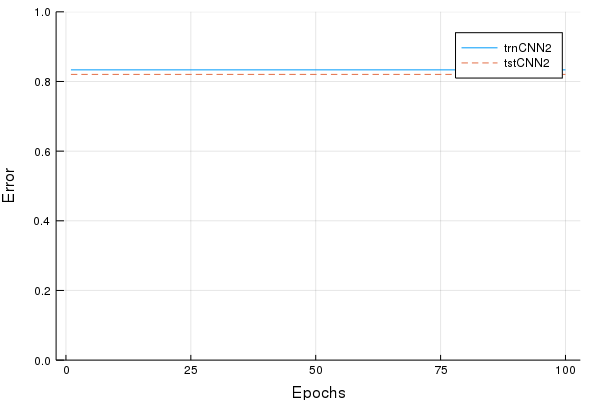

In [35]:
plot([cnn2[3,:], cnn2[4,:]], ylim=(0.0,1),
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Error")

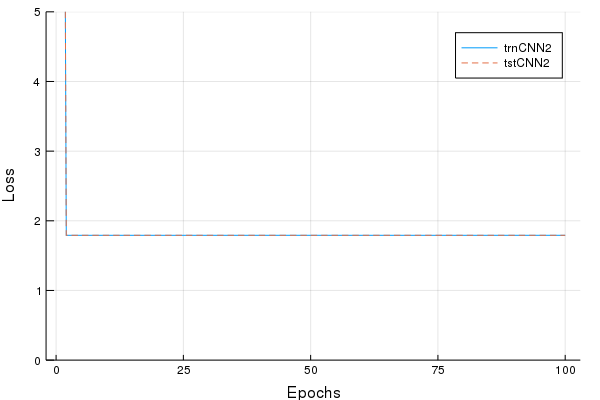

In [38]:
plot([cnn2[1,:], cnn2[2,:]], ylim=(0.0,5),
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Loss")

In [58]:
cnn1 = trainresults("cnn2.jld2", lenet2);

Train from scratch? stdin> y
1.55e+00  100.00%┣█████████████████████┫ 4500/4500 [09:00/09:00, 8.34i/s]
Float32[1.80996; 1.82021; 0.833333; 0.820313]


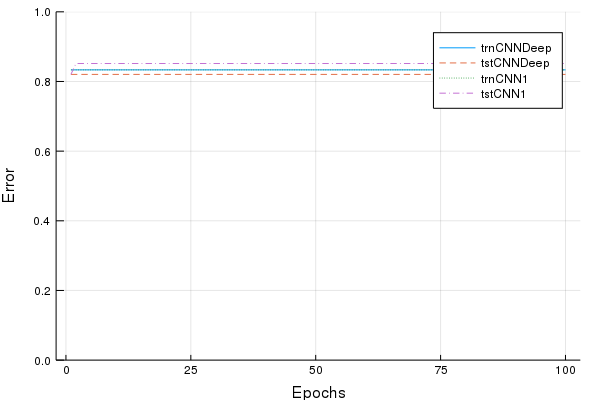

In [62]:
plot([cnn2[3,:], cnn2[4,:],cnn1[3,:], cnn1[4,:]], ylim=(0.0,1),
     labels=[:trnCNNDeep :tstCNNDeep :trnCNN1 :tstCNN1],xlabel="Epochs",ylabel="Error")

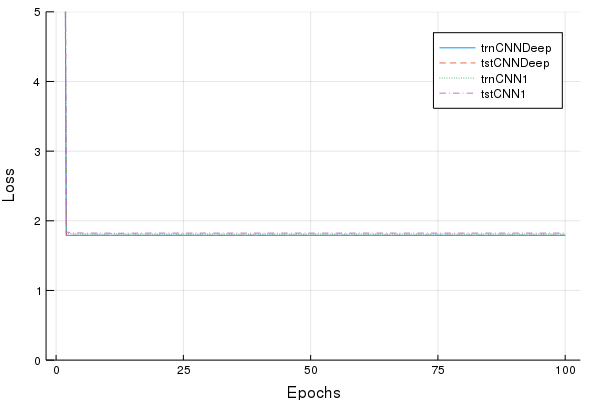

In [63]:
plot([cnn2[1,:], cnn2[2,:],cnn1[1,:], cnn1[2,:]], ylim=(0.0,5),
     labels=[:trnCNNDeep :tstCNNDeep :trnCNN1 :tstCNN1],xlabel="Epochs",ylabel="Loss")